# SETUP
---

## import packages

In [1]:
import pandas as pd
import numpy as np
import time

# file related packages
import glob
from fastparquet import ParquetFile

# model preparation
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# supervised learning algorithms
from sklearn.naive_bayes import MultinomialNB           # Multinomial Naive Bayes (Multi-class Classification)
from sklearn.neighbors import KNeighborsClassifier      # K Nearest Neighbor Classification
from sklearn.neighbors import KNeighborsRegressor       # K Nearest Neighbor Regression
from sklearn.ensemble import RandomForestClassifier     # Random Forest Classification
from sklearn.ensemble import RandomForestRegressor      # Random Forest Regression
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting Classification
from sklearn.ensemble import GradientBoostingRegressor  # Gradient Boosting Regression
from sklearn.svm import SVC                             # Support Vector Classification
from sklearn.svm import SVR                             # Support Vector Regression
from xgboost import XGBClassifier                       # Extreme Gradient Boosting Classification


# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

## set plot style

In [2]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to set plot style if no arguments provided
jtplot.style()

## define constants

In [3]:
VERBOSE = True
DEBUG = False
SAMPLE_RATE = 0.1
RANDOM_STATE = 1220
TRAIN_SIZE = 0.8
GRID_SEARCH = False

## load dataset

In [4]:
df = pd.read_csv('instacart_clustered.csv')
print(df.shape)
df.head()

(206059, 34)


user_id  d1  d2  d3  d4  d5  d6  d7  d8  d9  ...  order_number  order_dow  \
0        1   0   0   0   5   0   0  15   0   0  ...            11   2.636364   
1        2  17   0   2  36   0   3   9   0   0  ...            14   2.142857   
2        3   6   0   0  38   0   0   3   0   4  ...            13   1.384615   
3        4   3   0   2   2   2   0   3   0   0  ...             6   4.500000   
4        5   2   0   0  23   0   4   0   0   1  ...             5   1.400000   

   order_hour  days_elapsed  reord1_log1p  num_items_log1p  \
0   10.090909     17.272727      1.729239         1.996554   
1   10.571429     14.142857      2.033772         2.703277   
2   16.307692     11.076923      1.654558         2.050171   
3   12.500000     14.166667      0.154151         1.386294   
4   15.000000      9.200000      1.526056         2.322388   

   order_number_log1p  days_elapsed_log1p  Cluster1  Cluster2  
0            2.484907            2.905410         3         0  
1            2.708050            2.717529         3         0  
2            2.639057            2.491296         3         0  
3            1.945910            2.719100         1         2  
4            1.791759            2.322388         3         0  

[5 rows x 34 columns]

# HELPER FUNCTIONS
---

## feature importance

In [5]:
def get_feature_importance(rgr, X_, Y_,title='Feature Importance'):
    print('--- Feature Importance ---')
    
    # start timer
    t0 = time.time()
    
    # fit model
    rgr.fit(X_,Y_)

    try:
        # get feature importance
        fi = rgr.feature_importances_
    except:
        print('\t --- NOTE: Feature Importance Not Supported ---')
        return
    
    # Make importances relative to max importance.
    fi = 100.0 * (fi / fi.max())

    # get sort IDs to align with feature name
    sorted_idx = np.argsort(fi)
    
    # set figure size
    plt.rcParams['figure.figsize'] = (12,6)
    
    # plot bar plot
    sns.barplot(X_.columns[sorted_idx], fi[sorted_idx], palette='dark')
    plt.ylabel('Relative Importance')
    plt.xlabel('Feature')

    plt.xticks(rotation=90)
    plt.title(title, fontsize=18)

    plt.tight_layout()
    plt.show()
    print(f'Feature Importance completed in {time.time()-t0:.2f} seconds.')

## regression cross-validation

In [6]:
def run_regressor(X_, Y_, regressor='rfr',**kwargs):
    
    if VERBOSE:
        print(f'--- run_regresor(): kwargs = {kwargs} ---')

    # start timer
    t0 = time.time()
    
    # set plot size
    plt.rcParams['figure.figsize'] = (8,4)

    # choose classifier
    if VERBOSE:
        print('\t--- Selecting Regressor ---')
    if regressor == 'ols':
        rgr = LinearRegression()
    elif regressor == 'lasso':
        rgr = LassoCV(alphas=kwargs['alphas'], cv=kwargs['cv'])
    elif regressor == 'ridge':
        rgr = RidgeCV(alphas=kwargs['alphas'], cv=kwargs['cv'])
    elif regressor == 'elastic':
        rgr = ElasticNetCV(alphas=kwargs['alphas'], cv=kwargs['cv'], l1_ratio=kwargs['l1_ratio'])
    elif regressor == 'rfr':
        rgr = RandomForestRegressor(
            n_estimators=kwargs['n_estimators'], 
            criterion=kwargs['criterion'], 
            max_depth=kwargs['max_depth'], 
            bootstrap=kwargs['bootstrap']
        )
    elif regressor == 'gbr':
        rgr = GradientBoostingRegressor(
            learning_rate=kwargs['learning_rate'], 
            n_estimators=kwargs['n_estimators'],
            subsample=kwargs['subsample'],
            loss=kwargs['loss']
        )
    elif regressor == 'knn':
        rgr = KNeighborsRegressor(
            n_neighbors=kwargs['n_neighbors'],
            weights=kwargs['weights'],
            algorithm=kwargs['algorithm']
        )
    elif regressor == 'svr':
        rgr = SVR(
            C=kwargs['C'],
            kernel=kwargs['kernel']
        )
    else:
        raise 'Unknown classifier'

    # use stratified k-fold
    skf = StratifiedKFold(shuffle=True, n_splits=10)
    skf.get_n_splits(X_, Y_)        

    # run cross validation
    if VERBOSE:
        print('\t--- Executing cross-validation ---')
    cv = cross_val_score(rgr, X_, Y_, cv=10, scoring='neg_mean_squared_error')
    cv = cv * -1

    # convert results to single row dataframe
    cv = pd.DataFrame(cv).T

    # add mean
    cv['mean'] = cv.mean(axis=1)
    cv['std'] = cv.drop(['mean'],axis=1).std(axis=1)
    if VERBOSE:
        print('\t---',cv[['mean','std']],'---')

    # show cross validation heatmap
    plt.subplot(2,1,1)
    sns.heatmap(cv.drop(['std'],axis=1), cmap='RdYlGn_r', square=True, linewidth=0.5, annot=True, cbar=False)
    plt.yticks([])
    plt.xlabel('folds')
    plt.ylabel('score')
    plt.title('10-fold Cross Validation', fontsize=16)
              
    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.1)

    # execute fit on train dataset
    rgr.fit(X_train,y_train)
       
    if regressor in ['ols','lasso','ridge','elastic']:
        if regressor == 'ols':
            # add constant
            X_train = sm_.add_constant(X_train)

            # run statsmodels OLS
            results = sm_.OLS(y_train, X_train).fit()

            # print summary
            print(results.summary())
        else:
            print('\n--- Model Evaluation ---')
            print('Train R^2: ',rgr.score(X_train,y_train))
            print('Test R^2: ',rgr.score(X_test,y_test))
            
            print('\n--- Model Coefficients ---')
            print(rgr.coef_)
        
            print('\n--- Model Intercept (Constant) ---')
            print(rgr.intercept_)
            
            print('\n--- Best Alphas ---')
            print(rgr.alpha_)
            
            if regressor == 'elastic':
                print('\n--- l1 ratio ---')
                print(rgr.l1_ratio_)

    # get predictions on test dataset
    y_pred = rgr.predict(X_test)
    
    plt.tight_layout()
    plt.show()
    print(f'--- Completed in {(time.time() - t0):.4f} seconds\n')
    return y_test, y_pred

## error analysis

In [7]:
def regression_error_analysis(model, dfx_std, dfy_std, xscaler, yscaler, rgr, plot=True):
    print('--- Regression Error Analysis ---')
    t0 = time.time()
        
    # train test split 
    x_train = dfx_std.sample(frac=TRAIN_SIZE, random_state=RANDOM_STATE).values
    x_test = dfx_std.drop(dfx_std.sample(frac=TRAIN_SIZE, random_state=RANDOM_STATE).index).values
    y_train = dfy_std.sample(frac=TRAIN_SIZE, random_state=RANDOM_STATE).values.reshape(-1, 1)
    y_test = dfy_std.drop(dfy_std.sample(frac=TRAIN_SIZE, random_state=RANDOM_STATE).index). values.reshape(-1,1)
    
    if DEBUG:
        print(x_train.shape,x_test.shape)
        print(y_train.shape,y_test.shape)
    
    # fit model
    rgr.fit(x_train, y_train)
    
    # get predictions
    y_pred = rgr.predict(x_test)
    
    # inverse scaler transform
    targets = yscaler.inverse_transform(y_test)
    predictions = yscaler.inverse_transform(y_pred)

    # inverse log transform
    targets = np.expm1(targets)
    predictions = np.expm1(predictions)
    
    # add predictions and residuals to original dataframe
    test_df = model.drop(model.sample(frac=TRAIN_SIZE, random_state=RANDOM_STATE).index)
    test_df['predictions'] = predictions
    test_df['residuals'] = test_df.days_elapsed - test_df.predictions
    test_df.Cluster1 = test_df.Cluster1.astype(int)
    
    if DEBUG:
        print(test_df)
    
    if plot:
        # set figure size
        plt.rcParams['figure.figsize'] = (24,18)
        
        # predictions vs. days_elapsed
        plt.subplot(3,3,1)
        sns.scatterplot(data=test_df, x='days_elapsed', y='predictions', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('Actual Days Elapsed')
        plt.ylabel('Predicted Days Elapsed')
        plt.title('Predicted vs. Actual',fontsize=20)
        
        # residuals vs. days_elapsed
        plt.subplot(3,3,2)
        sns.scatterplot(data=test_df, x='days_elapsed', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('Days Elapsed')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Actual',fontsize=20)
        
        # residuals vs. order_number
        plt.subplot(3,3,3)
        sns.scatterplot(data=test_df, x='order_number', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('Number of Orders')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Number of Orders',fontsize=20)
        
        # residuals vs. num_items
        plt.subplot(3,3,4)
        sns.scatterplot(data=test_df, x='num_items', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('num_items')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Mean Number of Items Ordered',fontsize=20)
        
        # residuals vs. reord1
        plt.subplot(3,3,5)
        sns.scatterplot(data=test_df, x='reord1', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('reord1')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Mean Number of Items Re-Ordered',fontsize=20)
        
        # residuals vs. d4
        plt.subplot(3,3,6)
        sns.scatterplot(data=test_df, x='d4', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('d4')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Number of Produce Items Ordered',fontsize=20)
        
        # residuals vs. d16
        plt.subplot(3,3,7)
        sns.scatterplot(data=test_df, x='d16', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('d16')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Number of Dairy/Eggs Items Ordered',fontsize=20)
        
        # residuals vs. d7
        plt.subplot(3,3,8)
        sns.scatterplot(data=test_df, x='d7', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('d7')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Number of Beverage Items Ordered',fontsize=20)
        
        # residuals vs. d19
        plt.subplot(3,3,9)
        sns.scatterplot(data=test_df, x='d19', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('d19')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Number of Snack Items Ordered',fontsize=20)
        
        plt.tight_layout()
        plt.show()
    
    # error summary
    print(f'\t--- Error Analysis ---')
    print(f'\t--- RMSE={np.sqrt(np.mean((predictions-targets)**2)):.2f} ---')
    print(f'\t--- MSE={np.mean((predictions-targets)**2):.2f} ---')
    print(f'\t--- MAE={np.mean(np.absolute(predictions-targets)):.2f} ---')
    print(f'\t--- ME={np.mean(predictions-targets):.2f} ---')
    
    print(f'\n--- Regression Error Analysis Completed in {time.time()-t0:.2f} seconds ---')
    return test_df

# SUPERVISED LEARNING
---

## define model

In [8]:
# save off department list for later use
dept_list = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11',
             'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21']

In [9]:
def define_model(df_model, dept_PCA=True):
    print('--- Defining Model ---')
    
    # start timer
    t0 = time.time()
    
    # define input scaler
    x_scaler = StandardScaler()
    
    # do pca on departments
    if dept_PCA:
        depts = x_scaler.fit_transform(df_model.loc[:, 'd1':'d21'])
        pca = PCA(n_components=5)
        pca_data = pca.fit_transform(depts)

        print('\t--- PCA Results ---')
        print('\t--- % Variance explained by each component',pca.explained_variance_ratio_)
        print('\t--- % Varaince explained by all components:',f'{sum(pca.explained_variance_ratio_)*100:.2f}%')
    
    
    # select features
    if dept_PCA:
        df_model = df_model[['reord1','reord1_log1p','num_items','num_items_log1p','order_number','order_number_log1p','Cluster1','days_elapsed','days_elapsed_log1p']].copy()
    else:
        df_model = df_model[['reord1','reord1_log1p','num_items','num_items_log1p','order_number','order_number_log1p','Cluster1','days_elapsed','days_elapsed_log1p'] + dept_list].copy()
    
    # convert cluster designation to string (categorical variable)
    df_model.Cluster1 = df_model.Cluster1.astype(str)
    print('\t--- Initial Features Selected ---')
    
    if DEBUG:
        print('\t---',df_model.columns.to_list())
    
    # one-hot encoding
    X = pd.get_dummies(df_model.drop(['reord1','num_items','order_number','order_number_log1p','days_elapsed','days_elapsed_log1p',], axis=1), drop_first=True)
    print('\t--- One-Hot Encoding Completed ---')
    
    if DEBUG:
        print('\t---',X.columns.to_list())
    
    # standardize input variables
    X_std = x_scaler.fit_transform(X)
    print('\t--- Input Variable Standardization Completed ---')
    
    if DEBUG:
        print('\t---',X_std.shape)
    
    # add pca components
    if dept_PCA:
        X_std_orig = X_std
        X_std = np.concatenate((X_std_orig,pca_data),axis=1)
        df_X_std = pd.DataFrame(X_std)
        df_X_std.columns = X.columns.to_list() + ['pca1','pca2','pca3','pca4','pca5']
        print('\t--- PCA Components Added to Model ---')
    else:
        df_X_std = pd.DataFrame(X_std)
        df_X_std.columns = X.columns.to_list()
        
    if DEBUG:
            print('\t---',df_X_std.columns.to_list())
    
    # select output variable
    Y = df_model.days_elapsed_log1p

    # standardize output variables
    y_scaler = StandardScaler()
    Y_std = y_scaler.fit_transform(Y.values.reshape(-1,1))
    df_Y_std = pd.DataFrame(Y_std)
    print('\t--- Target Variable Defined and Standardized ---')
    
    if DEBUG:
        print('\t---',df_Y_std.columns.to_list())
    
    print(f'--- Model defined in {time.time()-t0} seconds ---')
    
    return df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y

In [10]:
# sample original dataframe
df_model = df.copy().sample(frac=SAMPLE_RATE , random_state=RANDOM_STATE)

# define model
df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y = define_model(df_model, False)

if VERBOSE:
    print(df_model.shape)
    print(df_X_std.shape)
    print(df_Y_std.shape)
    print(X_std.shape)
    print(Y_std.shape)

if DEBUG:
    print(df_model.head())
    print(df_X_std.head())
    print(df_Y_std.head())

--- Defining Model ---
	--- Initial Features Selected ---
	--- One-Hot Encoding Completed ---
	--- Input Variable Standardization Completed ---
	--- Target Variable Defined and Standardized ---
--- Model defined in 0.050864219665527344 seconds ---
(20606, 30)
(20606, 26)
(20606, 1)
(20606, 26)
(20606, 1)


## random forest regression

### default tuning

--- Random Forest Regression: Default Parameters ---
--- run_regresor(): kwargs = {'n_estimators': 100, 'criterion': 'mse', 'max_depth': None, 'bootstrap': True} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean       std
0  0.671902  0.026862 ---


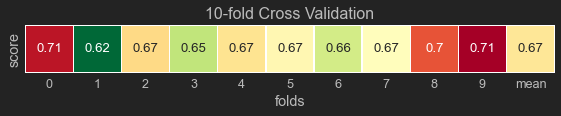

--- Completed in 181.1541 seconds



In [11]:
print('--- Random Forest Regression: Default Parameters ---')
actual, predicted = run_regressor(X_std, Y_std, 'rfr', n_estimators=100, criterion='mse', max_depth=None, bootstrap=True)

### grid search

In [12]:
if GRID_SEARCH:
    print('--- Random Forest Regression: Grid Search ---')

    # start timer
    t0 = time.time()

    # define regressor
    rgr = RandomForestRegressor()

    # define parameters
    param_grid = {
        'n_estimators':[50, 100, 200],
        'criterion':['mse','mae'],
        'max_depth':[None,4],
        'bootstrap':[True,False]
    }

    # run grid search
    grid = GridSearchCV(rgr, param_grid, refit=True)

    # fit to model
    grid.fit(X_std,Y_std)

    print('\t --- Best Parameters ---')
    print('\t',grid.best_params_)

    print(f'\t--- Random Forest Regression grid search completed in {time.time()-t0:.2f} seconds')

### post-tuning

--- Random Forest Regression: Tuned Parameters ---
--- run_regresor(): kwargs = {'n_estimators': 100, 'criterion': 'mse', 'max_depth': None, 'bootstrap': True} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean       std
0  0.673659  0.028036 ---


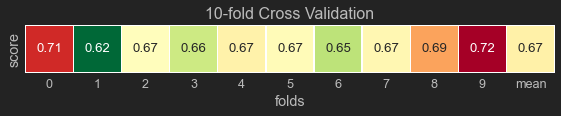

--- Completed in 181.1197 seconds



In [13]:
print('--- Random Forest Regression: Tuned Parameters ---')
actual, predicted = run_regressor(X_std, Y_std, 'rfr', n_estimators=100, criterion='mse', max_depth=None, bootstrap=True)

In [14]:
rgr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, bootstrap=True)

--- Feature Importance ---


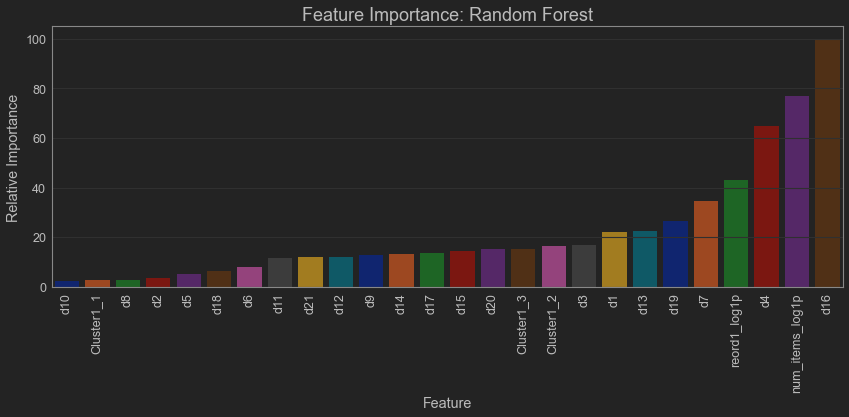

Feature Importance completed in 19.01 seconds.


In [15]:
# feature importance
rgr.fit(X_std,Y_std)
get_feature_importance(rgr, df_X_std, df_Y_std, 'Feature Importance: Random Forest')

--- Regression Error Analysis ---


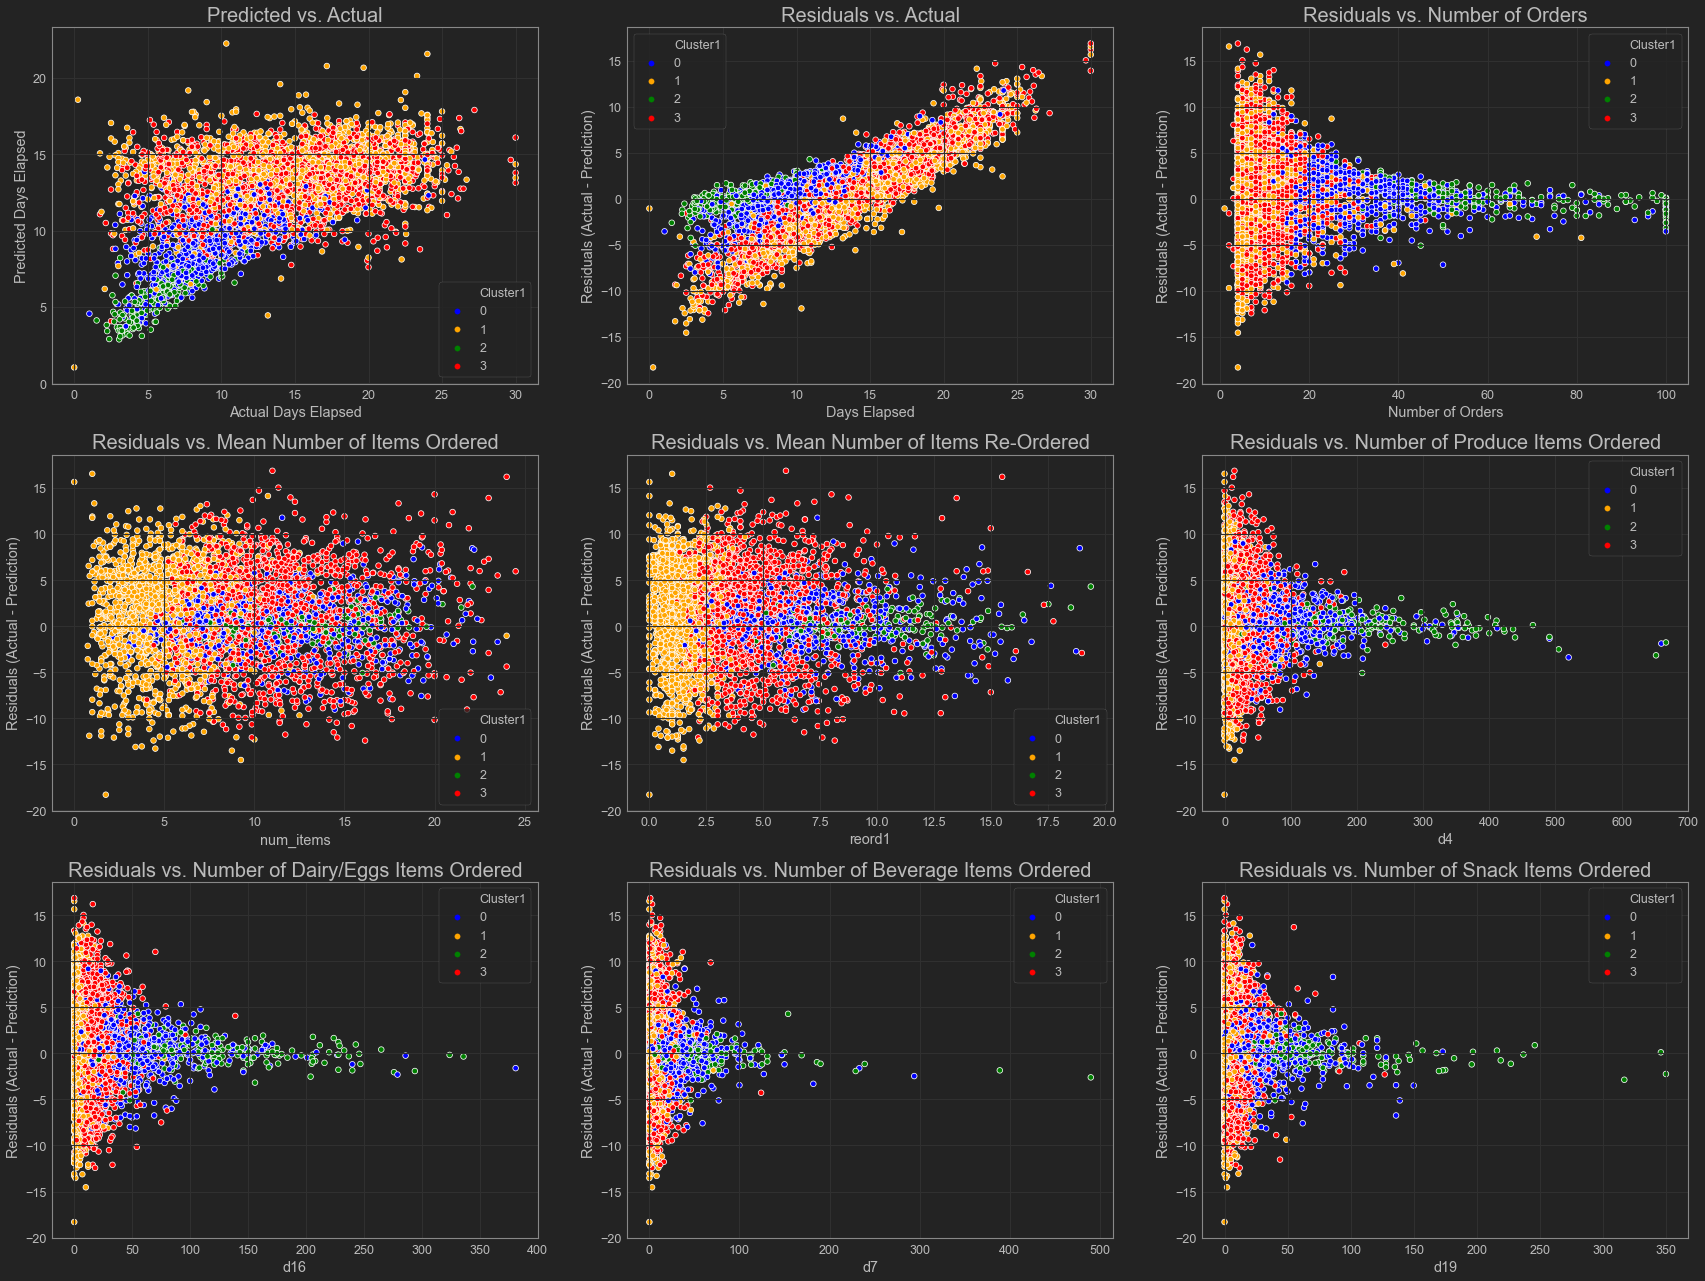

	--- Error Analysis ---
	--- RMSE=6.42 ---
	--- MSE=41.23 ---
	--- MAE=5.27 ---
	--- ME=-1.07 ---

--- Regression Error Analysis Completed in 18.19 seconds ---


reord1  reord1_log1p  num_items  num_items_log1p  order_number  \
81610    4.720930      1.744131   7.883721         2.184220            86   
17502    6.695652      2.040656   7.956522         2.192382            23   
23738    3.088235      1.408113   4.823529         1.761907            34   
47247    1.500000      0.916291   3.125000         1.417066             8   
75154   10.388889      2.432638  13.583333         2.679879            36   
...           ...           ...        ...              ...           ...   
71835    1.000000      0.693147   4.250000         1.658228             4   
110228   4.354839      1.678001   7.129032         2.095442            31   
171340   1.800000      1.029619   3.800000         1.568616             5   
121965  10.068966      2.404145  14.586207         2.746386            32   
106692   3.142857      1.421386   7.142857         2.097141             7   

        order_number_log1p  Cluster1  days_elapsed  days_elapsed_log1p  d1  \
81610             4.465908         2      4.244186            1.657120  28   
17502             3.178054         3     10.608696            2.451754   0   
23738             3.555348         3      8.411765            2.241960   2   
47247             2.197225         1     18.375000            2.963984   0   
75154             3.610918         0      9.222222            2.324564  12   
...                    ...       ...           ...                 ...  ..   
71835             1.609438         1     18.500000            2.970414   1   
110228            3.465736         0      8.032258            2.200802   4   
171340            1.791759         1     17.000000            2.890372   5   
121965            3.496508         0     11.310345            2.510440   3   
106692            2.079442         1     17.285714            2.906120   1   

        ...  d14  d15  d16  d17  d18  d19  d20  d21  predictions  residuals  
81610   ...   60   25  127    5   71   57    5    2     4.513811  -0.269625  
17502   ...    1    3   32    0   43   11   14    0    10.692176  -0.083480  
23738   ...    0   19   33    0    1    1    0    0     8.173225   0.238540  
47247   ...    0    0   16    0    0    5    0    0    11.311325   7.063675  
75154   ...   27    1   87    3    3   65    1    0     8.355653   0.866569  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...          ...        ...  
71835   ...    0    2    0    0    0    3    0    0    17.165975   1.334025  
110228  ...    0    6   45    1    0   26    3    0     8.296620  -0.264362  
171340  ...    0    0    7    0    0    5    0    0    12.081513   4.918487  
121965  ...   21   47   39   61    3   19    2    0    10.427144   0.883201  
106692  ...    1    0    6    1    0    3    7    0    14.073698   3.212016  

[4121 rows x 32 columns]

In [16]:
# error analysis: residuals
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr)

## gradient boosting regression

### default tuning

--- Gradient Boosting Regression: Default Parameters ---
--- run_regresor(): kwargs = {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1.0, 'loss': 'ls'} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean       std
0  0.654611  0.026958 ---


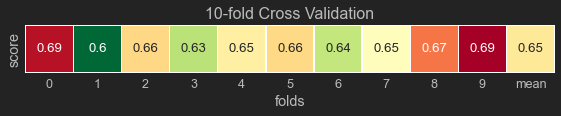

--- Completed in 38.8451 seconds



In [17]:
print('--- Gradient Boosting Regression: Default Parameters ---')
actual, predicted = run_regressor(X_std, Y_std, 'gbr',learning_rate=0.1, n_estimators=100, subsample=1.0, loss='ls')

### grid search

In [18]:
if GRID_SEARCH:
    print('--- Gradient Boosting Regression: Grid Search ---')

    # start timer
    t0 = time.time()

    # define regressor
    rgr = GradientBoostingRegressor()

    # define parameters
    param_grid = {
        'loss':['ls','lad','quantile'],
        'learning_rate':[0.1,0.9],
        'n_estimators':[100,300,500],
        'subsample':[0.1,1.0]
    }

    # run grid search
    grid = GridSearchCV(rgr, param_grid, refit=True)

    # fit to model
    grid.fit(X_std,Y_std)

    print('\t --- Best Parameters ---')
    print('\t',grid.best_params_)

    print(f'\t--- Gradient Boosting Regression grid search completed in {time.time()-t0:.2f} seconds')

### post-tuning

--- Gradient Boosting Regression: Tuned Parameters ---
--- run_regresor(): kwargs = {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1.0, 'loss': 'ls'} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean      std
0  0.654563  0.02701 ---


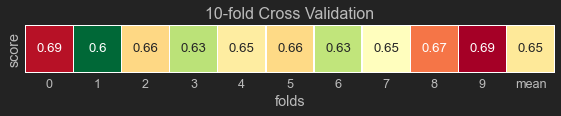

--- Completed in 38.9678 seconds



In [19]:
print('--- Gradient Boosting Regression: Tuned Parameters ---')
actual, predicted = run_regressor(X_std, Y_std, 'gbr',learning_rate=0.1, n_estimators=100, subsample=1.0, loss='ls')

In [20]:
rgr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, subsample=1.0, loss='ls')

--- Feature Importance ---


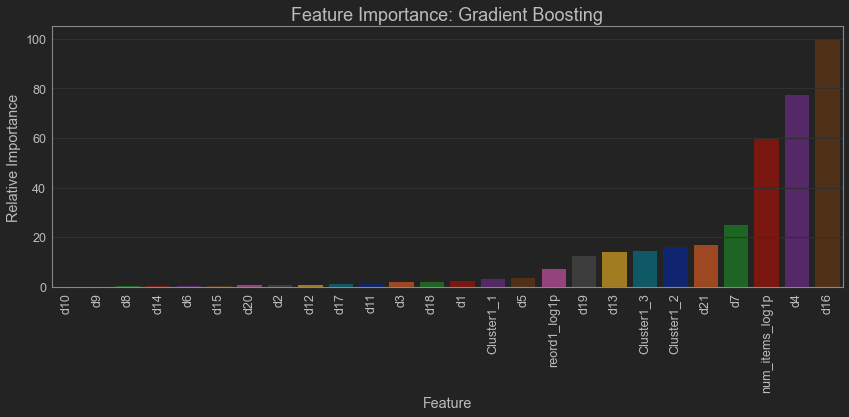

Feature Importance completed in 3.92 seconds.


In [21]:
# feature importance
rgr.fit(X_std,Y_std)
get_feature_importance(rgr, df_X_std, df_Y_std, 'Feature Importance: Gradient Boosting')

--- Regression Error Analysis ---


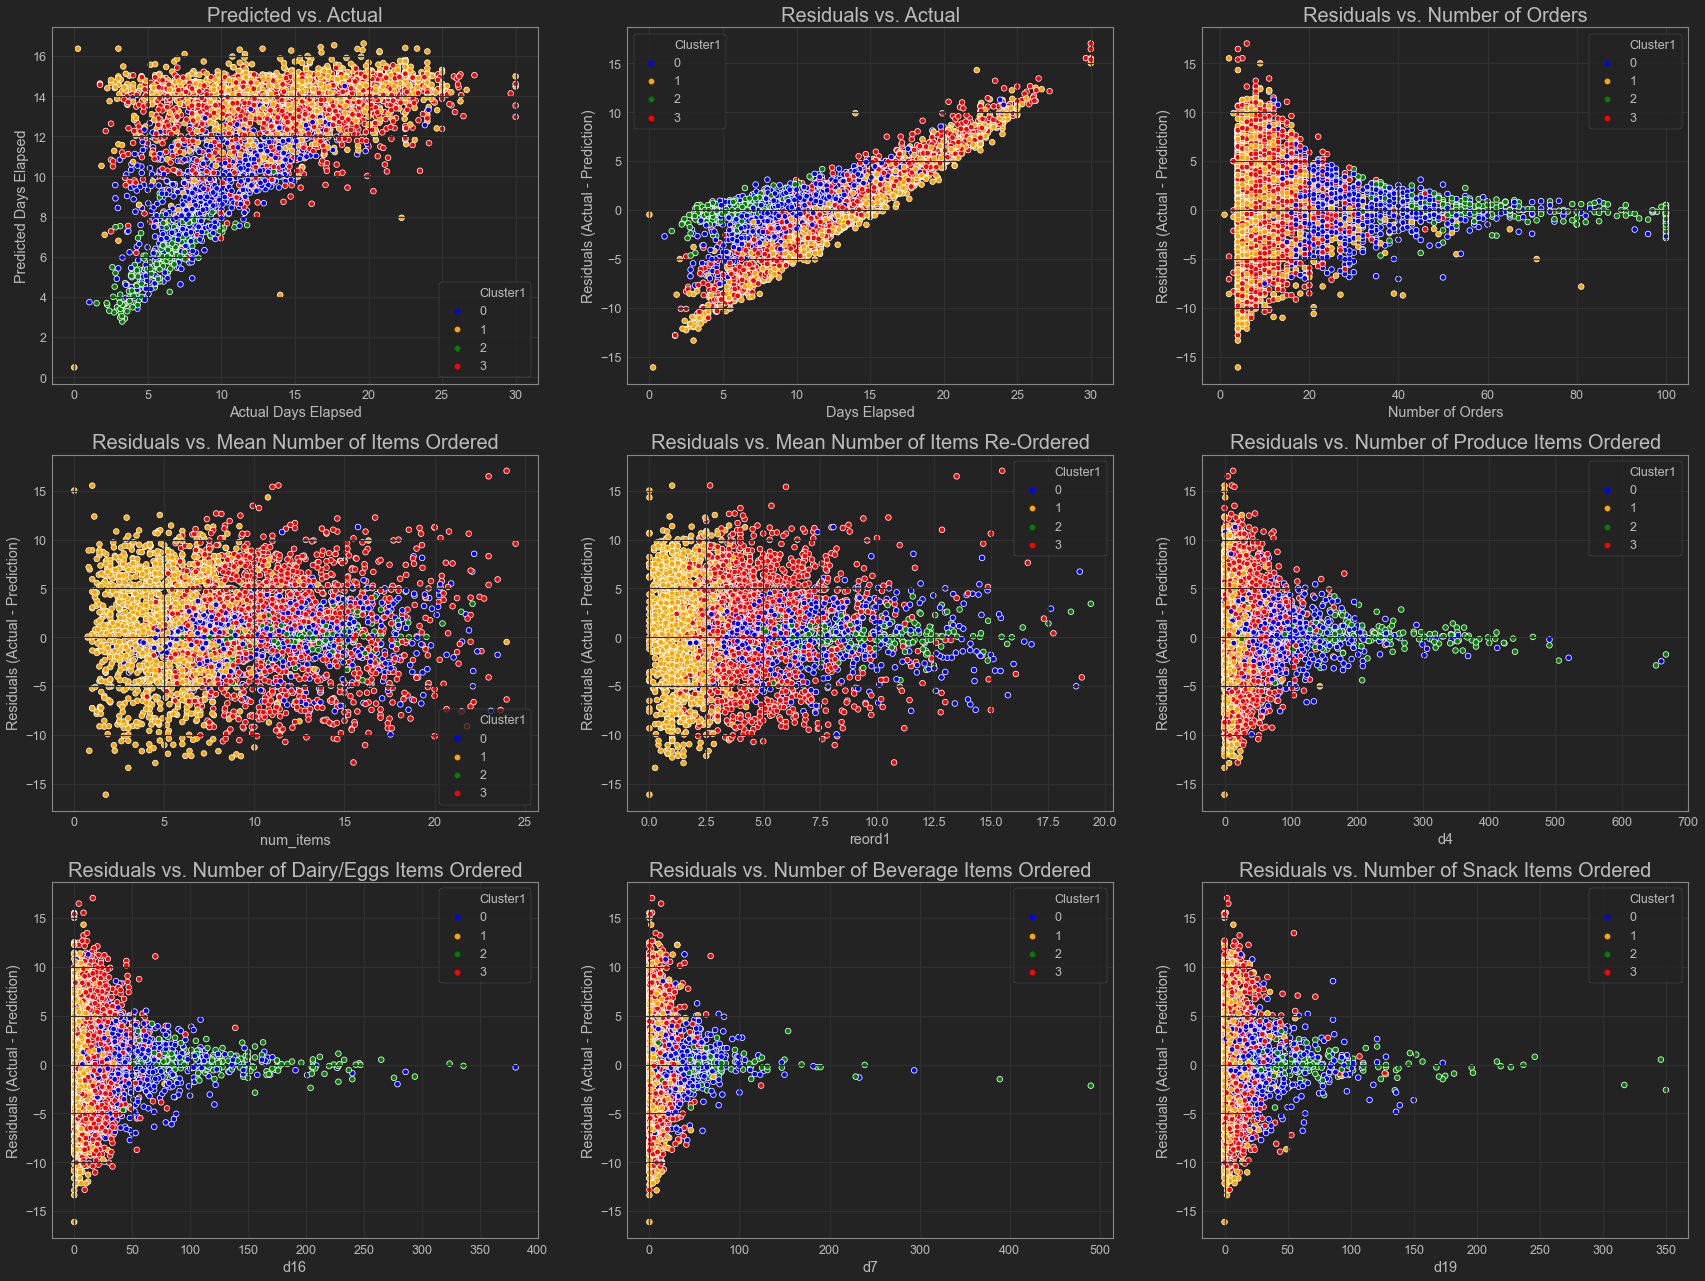

	--- Error Analysis ---
	--- RMSE=6.31 ---
	--- MSE=39.76 ---
	--- MAE=5.19 ---
	--- ME=-0.93 ---

--- Regression Error Analysis Completed in 6.28 seconds ---


reord1  reord1_log1p  num_items  num_items_log1p  order_number  \
81610    4.720930      1.744131   7.883721         2.184220            86   
17502    6.695652      2.040656   7.956522         2.192382            23   
23738    3.088235      1.408113   4.823529         1.761907            34   
47247    1.500000      0.916291   3.125000         1.417066             8   
75154   10.388889      2.432638  13.583333         2.679879            36   
...           ...           ...        ...              ...           ...   
71835    1.000000      0.693147   4.250000         1.658228             4   
110228   4.354839      1.678001   7.129032         2.095442            31   
171340   1.800000      1.029619   3.800000         1.568616             5   
121965  10.068966      2.404145  14.586207         2.746386            32   
106692   3.142857      1.421386   7.142857         2.097141             7   

        order_number_log1p  Cluster1  days_elapsed  days_elapsed_log1p  d1  \
81610             4.465908         2      4.244186            1.657120  28   
17502             3.178054         3     10.608696            2.451754   0   
23738             3.555348         3      8.411765            2.241960   2   
47247             2.197225         1     18.375000            2.963984   0   
75154             3.610918         0      9.222222            2.324564  12   
...                    ...       ...           ...                 ...  ..   
71835             1.609438         1     18.500000            2.970414   1   
110228            3.465736         0      8.032258            2.200802   4   
171340            1.791759         1     17.000000            2.890372   5   
121965            3.496508         0     11.310345            2.510440   3   
106692            2.079442         1     17.285714            2.906120   1   

        ...  d14  d15  d16  d17  d18  d19  d20  d21  predictions  residuals  
81610   ...   60   25  127    5   71   57    5    2     3.551465   0.692721  
17502   ...    1    3   32    0   43   11   14    0    11.733381  -1.124685  
23738   ...    0   19   33    0    1    1    0    0     8.159323   0.252442  
47247   ...    0    0   16    0    0    5    0    0    13.484646   4.890354  
75154   ...   27    1   87    3    3   65    1    0     8.013565   1.208657  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...          ...        ...  
71835   ...    0    2    0    0    0    3    0    0    14.950269   3.549731  
110228  ...    0    6   45    1    0   26    3    0     9.178776  -1.146518  
171340  ...    0    0    7    0    0    5    0    0    14.391094   2.608906  
121965  ...   21   47   39   61    3   19    2    0    10.402814   0.907531  
106692  ...    1    0    6    1    0    3    7    0    14.449113   2.836601  

[4121 rows x 32 columns]

In [22]:
# error analysis: residuals
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr)

## support vector regression

### default tuning

--- Support Vector Regression: Default Parameters ---
--- run_regresor(): kwargs = {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean       std
0  0.695983  0.033753 ---


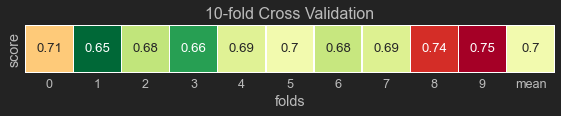

--- Completed in 202.4570 seconds



In [23]:
print('--- Support Vector Regression: Default Parameters ---')
actual, predicted = run_regressor(X_std,Y_std,'svr',C=1.0,kernel='rbf',gamma='scale')

### grid search

In [25]:
if GRID_SEARCH:
    print('--- Support Vector Regression: Grid Search')

    # start timer
    t0 = time.time()

    # define regressor
    rgr = SVR()

    # define parameters
    param_grid = {
        'C':[0.1, 1.0],
        'kernel':['linear','rbr','poly'],
        'gamma':['scale','auto']
    }

    # run grid search
    grid = GridSearchCV(rgr, param_grid, refit=True)

    # fit to model
    grid.fit(X_std,Y_std)

    print('\t --- Best Parameters ---')
    print('\t',grid.best_params_)

    print(f'\t--- SVM Regression grid search completed in {time.time()-t0:.2f} seconds')

### post-tuning

--- Support Vector Regression: Tuned Parameters ---
--- run_regresor(): kwargs = {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean       std
0  0.695983  0.033753 ---


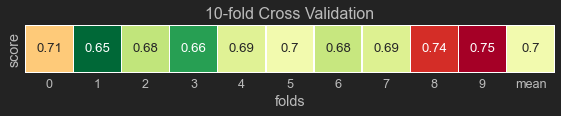

--- Completed in 199.4417 seconds



In [26]:
print('--- Support Vector Regression: Tuned Parameters ---')
actual, predicted = run_regressor(X_std,Y_std,'svr',C=1.0,kernel='rbf',gamma='scale')

In [27]:
rgr = SVR(C=1.0, kernel='rbf', gamma='scale')

--- Regression Error Analysis ---


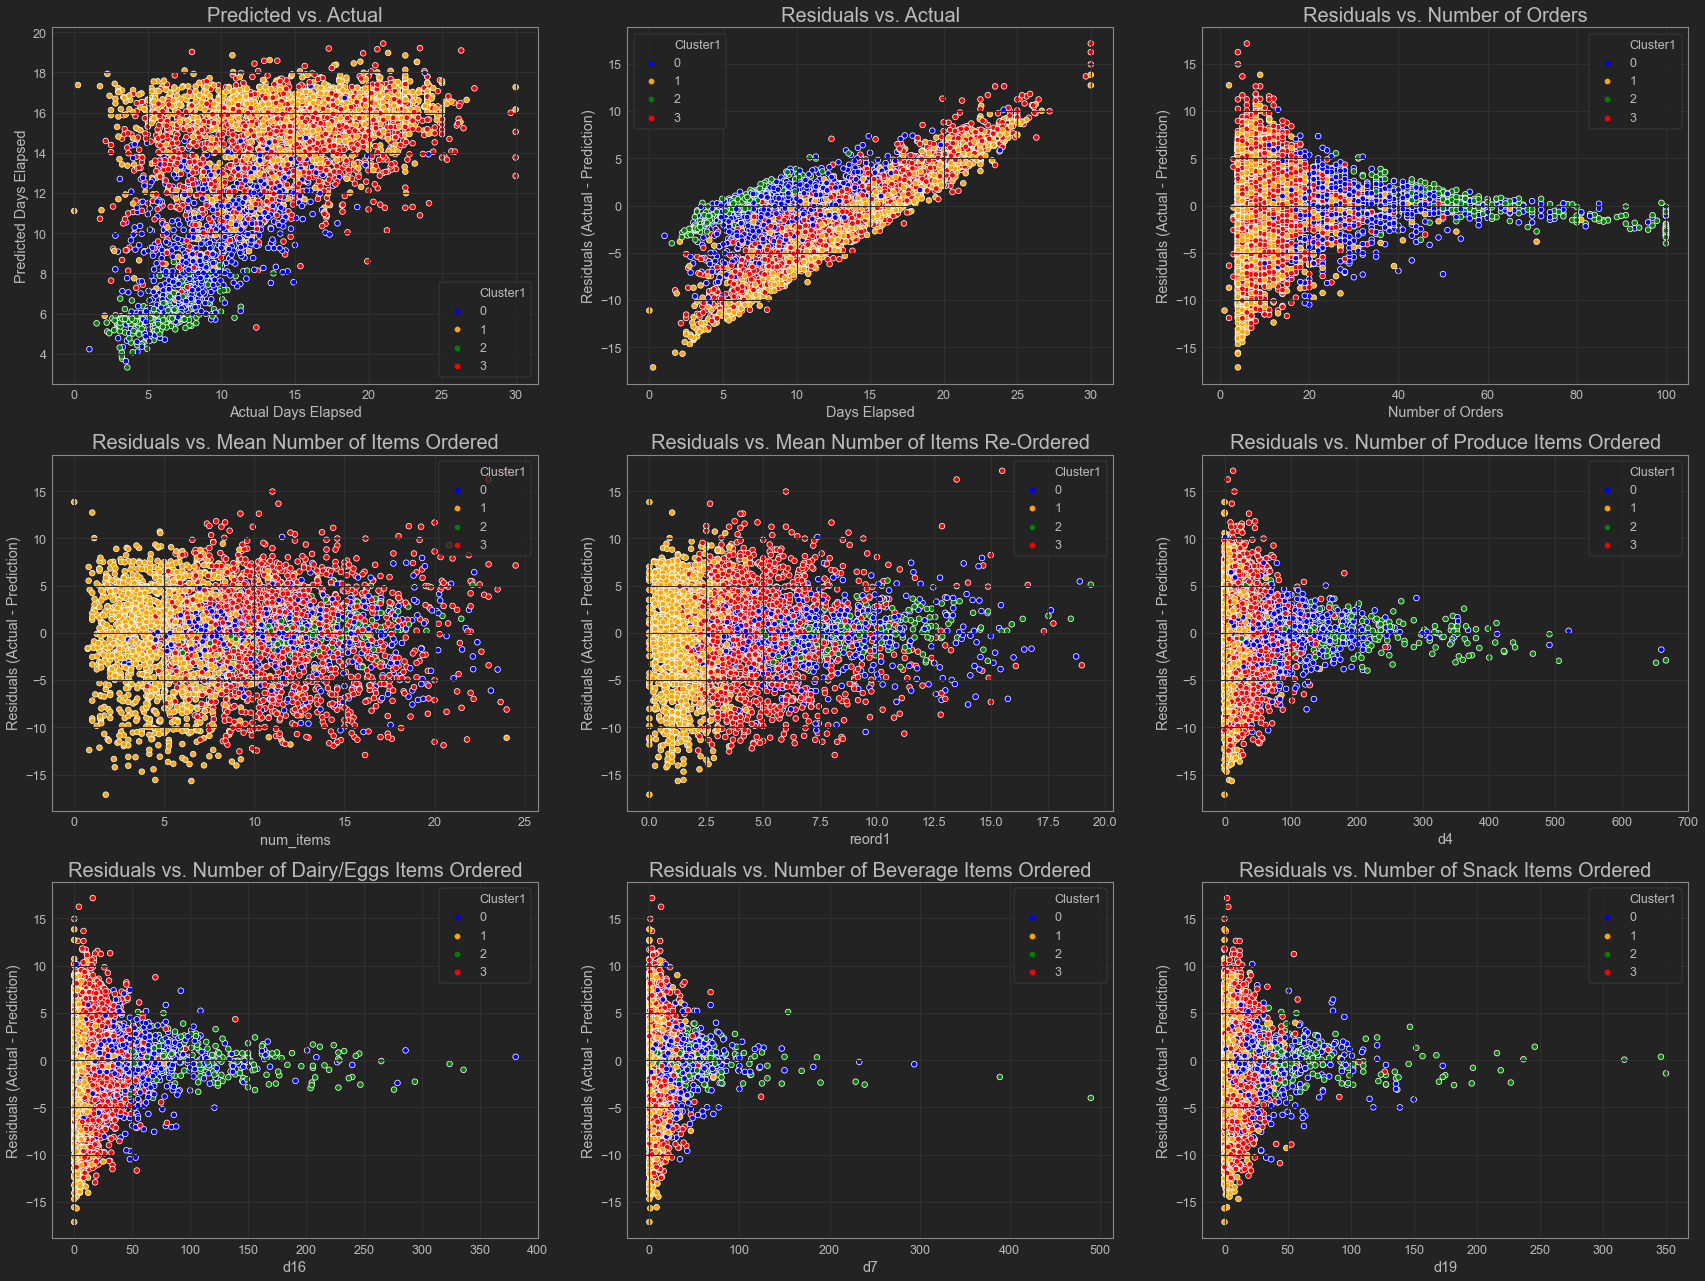

	--- Error Analysis ---
	--- RMSE=6.56 ---
	--- MSE=42.98 ---
	--- MAE=5.38 ---
	--- ME=0.22 ---

--- Regression Error Analysis Completed in 18.80 seconds ---


reord1  reord1_log1p  num_items  num_items_log1p  order_number  \
81610    4.720930      1.744131   7.883721         2.184220            86   
17502    6.695652      2.040656   7.956522         2.192382            23   
23738    3.088235      1.408113   4.823529         1.761907            34   
47247    1.500000      0.916291   3.125000         1.417066             8   
75154   10.388889      2.432638  13.583333         2.679879            36   
...           ...           ...        ...              ...           ...   
71835    1.000000      0.693147   4.250000         1.658228             4   
110228   4.354839      1.678001   7.129032         2.095442            31   
171340   1.800000      1.029619   3.800000         1.568616             5   
121965  10.068966      2.404145  14.586207         2.746386            32   
106692   3.142857      1.421386   7.142857         2.097141             7   

        order_number_log1p  Cluster1  days_elapsed  days_elapsed_log1p  d1  \
81610             4.465908         2      4.244186            1.657120  28   
17502             3.178054         3     10.608696            2.451754   0   
23738             3.555348         3      8.411765            2.241960   2   
47247             2.197225         1     18.375000            2.963984   0   
75154             3.610918         0      9.222222            2.324564  12   
...                    ...       ...           ...                 ...  ..   
71835             1.609438         1     18.500000            2.970414   1   
110228            3.465736         0      8.032258            2.200802   4   
171340            1.791759         1     17.000000            2.890372   5   
121965            3.496508         0     11.310345            2.510440   3   
106692            2.079442         1     17.285714            2.906120   1   

        ...  d14  d15  d16  d17  d18  d19  d20  d21  predictions  residuals  
81610   ...   60   25  127    5   71   57    5    2     5.797598  -1.553412  
17502   ...    1    3   32    0   43   11   14    0    10.692378  -0.083682  
23738   ...    0   19   33    0    1    1    0    0     9.914327  -1.502563  
47247   ...    0    0   16    0    0    5    0    0    15.657236   2.717764  
75154   ...   27    1   87    3    3   65    1    0     6.506950   2.715272  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...          ...        ...  
71835   ...    0    2    0    0    0    3    0    0    17.747561   0.752439  
110228  ...    0    6   45    1    0   26    3    0     8.956122  -0.923864  
171340  ...    0    0    7    0    0    5    0    0    16.485070   0.514930  
121965  ...   21   47   39   61    3   19    2    0     6.135439   5.174906  
106692  ...    1    0    6    1    0    3    7    0    15.422816   1.862899  

[4121 rows x 32 columns]

In [28]:
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr)

## knn regression

### default tuning

--- KNN Regression: Default Parameters ---
--- run_regresor(): kwargs = {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto'} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean       std
0  0.802414  0.031193 ---


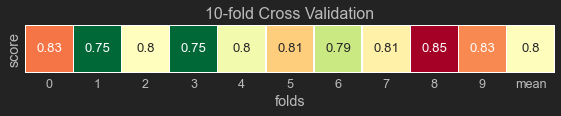

--- Completed in 22.1488 seconds



In [29]:
print('--- KNN Regression: Default Parameters ---')
actual, predicted = run_regressor(X_std, Y_std, 'knn',n_neighbors=5,weights='uniform', algorithm='auto')

### grid search

In [30]:
if GRID_SEARCH:
    print('--- KNN Regression: Grid Search ---')

    # start timer
    t0 = time.time()

    # define regressor
    rgr=KNeighborsRegressor()

    # define parameters
    param_grid = {
        'n_neighbors':[5,10,20,50,100],
        'weights':['uniform','distance'],
        'algorithm':['auto','ball_tree','kd_tree','brute']
    }

    # run grid search
    grid = GridSearchCV(rgr, param_grid, refit=True)

    # fit to model
    grid.fit(X_std,Y_std)

    print('\t --- Best Parameters ---')
    print('\t',grid.best_params_)

    print(f'\t--- KNN Regression grid search completed in {time.time()-t0:.2f} seconds')

### post-tuning

--- KNN Regression: Tuned Parameters ---
--- run_regresor(): kwargs = {'n_neighbors': 50, 'weights': 'distance', 'algorithm': 'ball_tree'} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean       std
0  0.712319  0.030637 ---


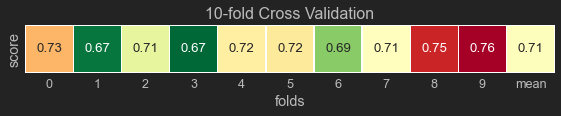

--- Completed in 20.8633 seconds



In [31]:
print('--- KNN Regression: Tuned Parameters ---')
actual, predicted = run_regressor(X_std, Y_std, 'knn',n_neighbors=50,weights='distance',algorithm='ball_tree')

In [32]:
rgr = KNeighborsRegressor(n_neighbors=50, weights='distance',algorithm='ball_tree')

--- Regression Error Analysis ---


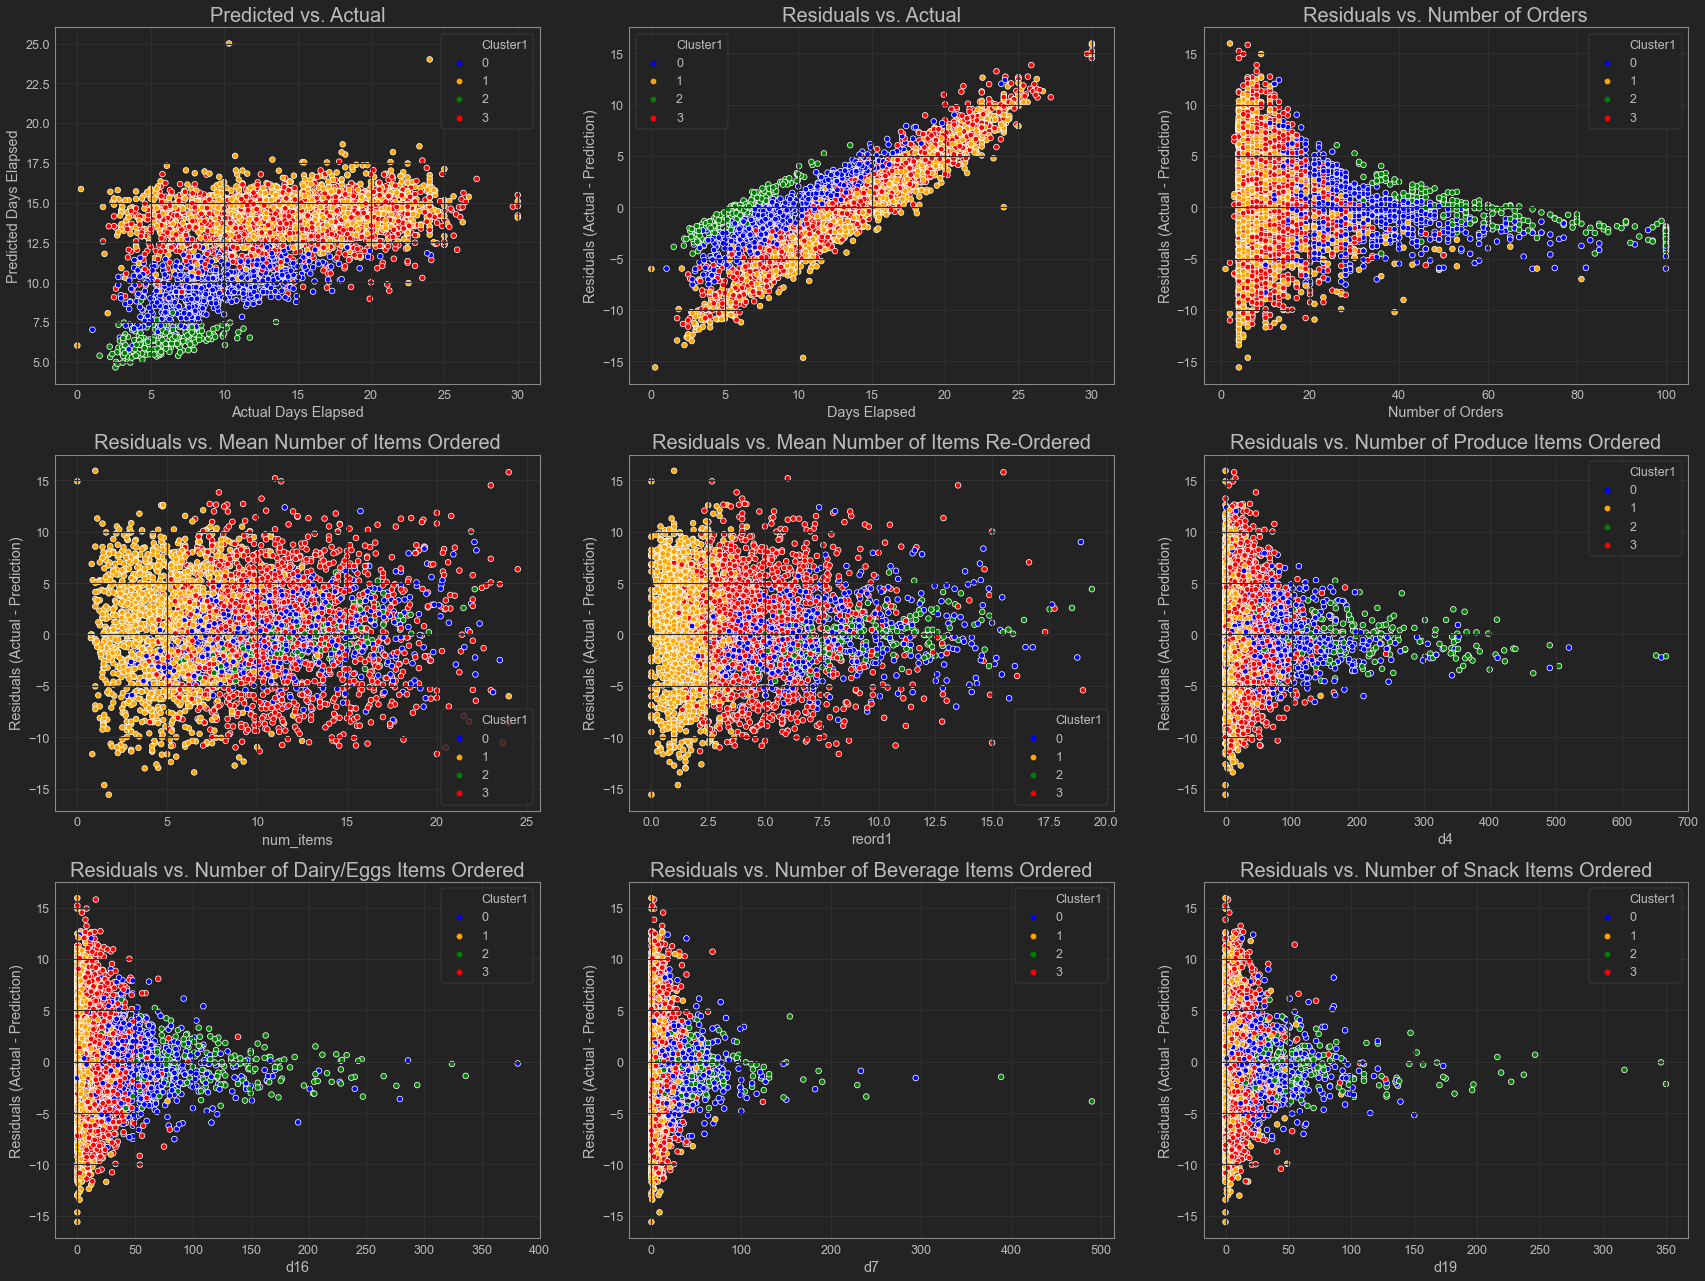

	--- Error Analysis ---
	--- RMSE=4.77 ---
	--- MSE=22.79 ---
	--- MAE=3.81 ---
	--- ME=-0.49 ---

--- Regression Error Analysis Completed in 5.48 seconds ---


reord1  reord1_log1p  num_items  num_items_log1p  order_number  \
81610    4.720930      1.744131   7.883721         2.184220            86   
17502    6.695652      2.040656   7.956522         2.192382            23   
23738    3.088235      1.408113   4.823529         1.761907            34   
47247    1.500000      0.916291   3.125000         1.417066             8   
75154   10.388889      2.432638  13.583333         2.679879            36   
...           ...           ...        ...              ...           ...   
71835    1.000000      0.693147   4.250000         1.658228             4   
110228   4.354839      1.678001   7.129032         2.095442            31   
171340   1.800000      1.029619   3.800000         1.568616             5   
121965  10.068966      2.404145  14.586207         2.746386            32   
106692   3.142857      1.421386   7.142857         2.097141             7   

        order_number_log1p  Cluster1  days_elapsed  days_elapsed_log1p  d1  \
81610             4.465908         2      4.244186            1.657120  28   
17502             3.178054         3     10.608696            2.451754   0   
23738             3.555348         3      8.411765            2.241960   2   
47247             2.197225         1     18.375000            2.963984   0   
75154             3.610918         0      9.222222            2.324564  12   
...                    ...       ...           ...                 ...  ..   
71835             1.609438         1     18.500000            2.970414   1   
110228            3.465736         0      8.032258            2.200802   4   
171340            1.791759         1     17.000000            2.890372   5   
121965            3.496508         0     11.310345            2.510440   3   
106692            2.079442         1     17.285714            2.906120   1   

        ...  d14  d15  d16  d17  d18  d19  d20  d21  predictions  residuals  
81610   ...   60   25  127    5   71   57    5    2     6.405047  -2.160861  
17502   ...    1    3   32    0   43   11   14    0    12.390765  -1.782069  
23738   ...    0   19   33    0    1    1    0    0    12.185857  -3.774092  
47247   ...    0    0   16    0    0    5    0    0    13.763329   4.611671  
75154   ...   27    1   87    3    3   65    1    0     8.875849   0.346374  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...          ...        ...  
71835   ...    0    2    0    0    0    3    0    0    15.800516   2.699484  
110228  ...    0    6   45    1    0   26    3    0     8.197738  -0.165480  
171340  ...    0    0    7    0    0    5    0    0    13.581746   3.418254  
121965  ...   21   47   39   61    3   19    2    0     9.289522   2.020823  
106692  ...    1    0    6    1    0    3    7    0    15.694468   1.591246  

[4121 rows x 32 columns]

In [33]:
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr)

### knn on population

In [34]:
# copy original dataframe
df_model = df.copy()

# define model
df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y = define_model(df_model, False)

if VERBOSE:
    print(df_model.shape)
    print(df_X_std.shape)
    print(df_Y_std.shape)
    print(X_std.shape)
    print(Y_std.shape)

if DEBUG:
    print(df_model.head())
    print(df_X_std.head())
    print(df_Y_std.head())

--- Defining Model ---
	--- Initial Features Selected ---
	--- One-Hot Encoding Completed ---
	--- Input Variable Standardization Completed ---
	--- Target Variable Defined and Standardized ---
--- Model defined in 0.47971630096435547 seconds ---
(206059, 30)
(206059, 26)
(206059, 1)
(206059, 26)
(206059, 1)


In [35]:
rgr = KNeighborsRegressor(n_neighbors=50, weights='distance',algorithm='ball_tree')

--- Regression Error Analysis ---


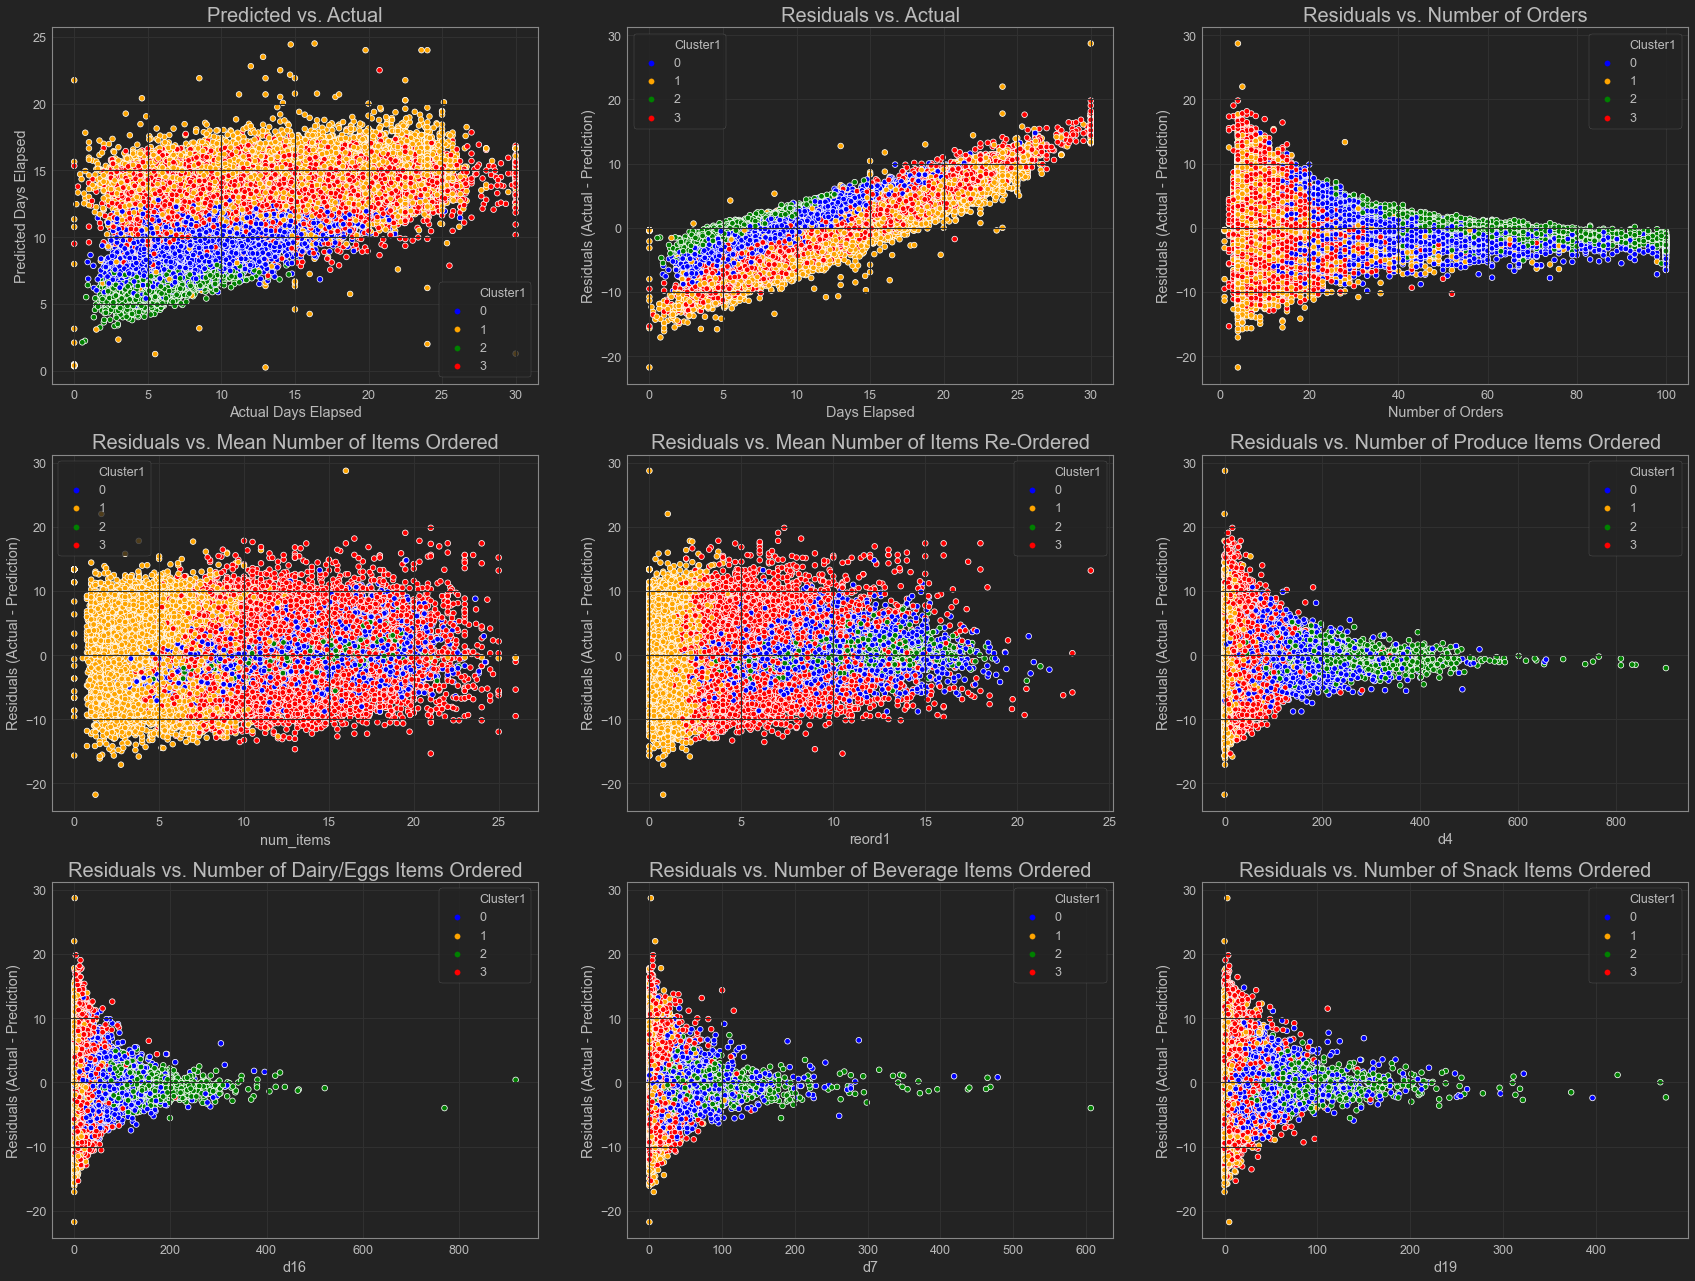

	--- Error Analysis ---
	--- RMSE=4.74 ---
	--- MSE=22.42 ---
	--- MAE=3.74 ---
	--- ME=-0.58 ---

--- Regression Error Analysis Completed in 587.54 seconds ---


reord1  reord1_log1p  num_items  num_items_log1p  order_number  \
1       6.642857      2.033772  13.928571         2.703277            14   
14      2.565217      1.271225   3.130435         1.418383            23   
46      0.833333      0.606136   5.333333         1.845827             6   
50      1.250000      0.810930   7.250000         2.110213             4   
54      6.500000      2.014903  12.500000         2.602690             8   
...          ...           ...        ...              ...           ...   
206028  2.250000      1.178655  11.000000         2.484907             4   
206033  0.400000      0.336472   7.400000         2.128232             5   
206041  4.400000      1.686399   6.866667         2.062634            15   
206049  7.090909      2.090741  10.954545         2.481112            24   
206052  7.500000      2.140066  19.000000         2.995732             6   

        order_number_log1p  Cluster1  days_elapsed  days_elapsed_log1p  d1  \
1                 2.708050         3     14.142857            2.717529  17   
14                3.178054         1     10.173913            2.413582   0   
46                1.945910         1      8.000000            2.197225   4   
50                1.609438         1     11.500000            2.525729   0   
54                2.197225         3     17.000000            2.890372   6   
...                    ...       ...           ...                 ...  ..   
206028            1.609438         3     16.750000            2.876386   1   
206033            1.791759         1     20.000000            3.044522   9   
206041            2.772589         3     11.333333            2.512306  15   
206049            3.218876         0      9.000000            2.302585  24   
206052            1.945910         3     22.500000            3.157000  10   

        ...  d14  d15  d16  d17  d18  d19  d20  d21  predictions  residuals  
1       ...    3    1   48    0    0   42   21    0    14.310136  -0.167279  
14      ...    0    0    0    1    0   51    0    0    11.613770  -1.439857  
46      ...    0    2    7    0    1    2    0    1    11.572104  -3.572104  
50      ...    2    2   11    0    0    3    3    0    14.622121  -3.122121  
54      ...    1    1   15    0    0   31    4    0    12.911245   4.088755  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...          ...        ...  
206028  ...    1    0   14    1    0    0    2    0    13.380979   3.369021  
206033  ...    0    2    4    0    0    0    2    0    14.700026   5.299974  
206041  ...    3    2    6    1    0   24    7    0    14.346180  -3.012847  
206049  ...    0   13   18    0    0   15    2    7     8.629963   0.370037  
206052  ...    0    3    8    1    0   11    0    0    14.474630   8.025370  

[41212 rows x 32 columns]

In [36]:
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr)

### per cluster RMSE

#### cluster0

In [37]:
df_model = df.copy()
df_model = df_model[df_model.Cluster1==0]
df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y = define_model(df_model, False)
rgr = KNeighborsRegressor(n_neighbors=50, weights='distance',algorithm='ball_tree')
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr, False)

--- Defining Model ---
	--- Initial Features Selected ---
	--- One-Hot Encoding Completed ---
	--- Input Variable Standardization Completed ---
	--- Target Variable Defined and Standardized ---
--- Model defined in 0.08876323699951172 seconds ---
--- Regression Error Analysis ---
	--- Error Analysis ---
	--- RMSE=2.77 ---
	--- MSE=7.68 ---
	--- MAE=2.14 ---
	--- ME=0.04 ---

--- Regression Error Analysis Completed in 9.04 seconds ---


reord1  reord1_log1p  num_items  num_items_log1p  order_number  \
37       9.000000      2.302585  16.461538         2.860001            13   
88       8.142857      2.212973  12.047619         2.568606            21   
148      7.312500      2.117760  14.250000         2.724580            16   
154      8.434783      2.244403  10.608696         2.451754            23   
196     11.142857      2.496741  18.857143         2.988564            20   
...           ...           ...        ...              ...           ...   
205848  16.631579      2.869692  20.105263         3.049522            22   
205956   4.250000      1.658228  12.400000         2.595255            20   
205958   2.281250      1.188224   6.437500         2.006535            32   
206003   9.333333      2.335375  10.777778         2.466215            27   
206014   5.578947      1.883875  11.526316         2.527832            28   

        order_number_log1p  Cluster1  days_elapsed  days_elapsed_log1p  d1  \
37                2.639057         0     20.076923            3.048179  22   
88                3.091042         0      8.761905            2.278488   1   
148               2.833213         0     15.875000            2.825833  39   
154               3.178054         0     14.652174            2.750610  11   
196               3.044522         0      2.571429            1.272966  22   
...                    ...       ...           ...                 ...  ..   
205848            3.135494         0     13.631579            2.683182  26   
205956            3.044522         0     18.200000            2.954910  12   
205958            3.496508         0     10.031250            2.400732  11   
206003            3.332205         0     13.370370            2.665168  23   
206014            3.367296         0     10.526316            2.444633  18   

        ...  d14  d15  d16  d17  d18  d19  d20  d21  predictions  residuals  
37      ...    0    6   53    7    0   14   11    0    12.028405   8.048518  
88      ...    0   59   39    0    0   10   21    2    11.652646  -2.890741  
148     ...    8    7   40    3    0   16    7    0    12.034774   3.840226  
154     ...    0    0   41    0    0    7   47    0    10.502769   4.149405  
196     ...    0    2   81    2    0   16    4    0    10.406768  -7.835340  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...          ...        ...  
205848  ...    5   23   77    0    0   52   13    0    10.815103   2.816476  
205956  ...    3   19   44   25    0   10   10    0    10.882784   7.317216  
205958  ...    4    0   30    3    0   40   25    0     7.269769   2.761481  
206003  ...    0    2   61   13    0   11    0    0     9.799063   3.571308  
206014  ...    3   15   35   23    1   14    3    0    11.404874  -0.878558  

[7143 rows x 32 columns]

#### cluster1

In [38]:
df_model = df.copy()
df_model = df_model[df_model.Cluster1==1]
df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y = define_model(df_model, False)
rgr = KNeighborsRegressor(n_neighbors=50, weights='distance',algorithm='ball_tree')
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr, False)

--- Defining Model ---
	--- Initial Features Selected ---
	--- One-Hot Encoding Completed ---
	--- Input Variable Standardization Completed ---
	--- Target Variable Defined and Standardized ---
--- Model defined in 0.17752480506896973 seconds ---
--- Regression Error Analysis ---
	--- Error Analysis ---
	--- RMSE=5.34 ---
	--- MSE=28.50 ---
	--- MAE=4.40 ---
	--- ME=-0.70 ---

--- Regression Error Analysis Completed in 49.80 seconds ---


reord1  reord1_log1p  num_items  num_items_log1p  order_number  \
5       0.500000      0.405465   3.500000         1.504077             4   
50      1.250000      0.810930   7.250000         2.110213             4   
65      1.142857      0.762140   4.285714         1.665008             7   
73      1.166667      0.773190   8.833333         2.285778             6   
103     1.833333      1.041454   4.833333         1.763589             6   
...          ...           ...        ...              ...           ...   
205938  0.777778      0.575364   1.111111         0.747214             9   
205985  1.636364      0.969401   5.363636         1.850600            11   
206012  1.000000      0.693147   2.166667         1.152680             6   
206020  1.285714      0.826679   4.000000         1.609438             7   
206033  0.400000      0.336472   7.400000         2.128232             5   

        order_number_log1p  Cluster1  days_elapsed  days_elapsed_log1p  d1  \
5                 1.609438         1     10.000000            2.397895   0   
50                1.609438         1     11.500000            2.525729   0   
65                2.079442         1     24.714286            3.247047   1   
73                1.945910         1     13.333333            2.662588   1   
103               1.945910         1     14.333333            2.730029   0   
...                    ...       ...           ...                 ...  ..   
205938            2.302585         1     17.888889            2.938574   0   
205985            2.484907         1      4.727273            1.745239   0   
206012            1.945910         1     25.000000            3.258097   1   
206020            2.079442         1     13.714286            2.688819   0   
206033            1.791759         1     20.000000            3.044522   9   

        ...  d14  d15  d16  d17  d18  d19  d20  d21  predictions  residuals  
5       ...    0    3    2    0    0    0    0    0    14.165344  -4.165344  
50      ...    2    2   11    0    0    3    3    0    15.536879  -4.036879  
65      ...    1    0    4    0    0    6    0    0    14.982601   9.731685  
73      ...    1    9    5    3    0    1    1    0    16.931608  -3.598275  
103     ...    0    0    3    0    0    0   25    1    11.511942   2.821392  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...          ...        ...  
205938  ...    0    0    0    1    0    0    0    0    18.023051  -0.134163  
205985  ...    0    5   12    2    0    7    0    0    16.374952 -11.647679  
206012  ...    0    0    0    3    0    0    0    0    18.514002   6.485998  
206020  ...    0    0    7    0    0    5    0    0    14.500114  -0.785828  
206033  ...    0    2    4    0    0    0    2    0    14.676207   5.323793  

[15274 rows x 32 columns]

#### cluster2

In [39]:
df_model = df.copy()
df_model = df_model[df_model.Cluster1==2]
df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y = define_model(df_model, False)
rgr = KNeighborsRegressor(n_neighbors=50, weights='distance',algorithm='ball_tree')
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr, False)

--- Defining Model ---
	--- Initial Features Selected ---
	--- One-Hot Encoding Completed ---
	--- Input Variable Standardization Completed ---
	--- Target Variable Defined and Standardized ---
--- Model defined in 0.029919862747192383 seconds ---
--- Regression Error Analysis ---
	--- Error Analysis ---
	--- RMSE=1.25 ---
	--- MSE=1.57 ---
	--- MAE=0.97 ---
	--- ME=0.24 ---

--- Regression Error Analysis Completed in 0.60 seconds ---


reord1  reord1_log1p  num_items  num_items_log1p  order_number  \
26       6.853659      2.060979   9.573171         2.358320            82   
784      8.072165      2.205211   9.628866         2.363574           100   
854      9.914894      2.390128  11.702128         2.541770            47   
1015     9.197674      2.322160  11.627907         2.535909            87   
1500    11.114286      2.494385  15.457143         2.800760            35   
...           ...           ...        ...              ...           ...   
205428   9.016949      2.304279  11.677966         2.539866            63   
205457   9.700000      2.370244  13.480000         2.672768            50   
205480  11.396226      2.517392  15.773585         2.819805            60   
205821   7.750000      2.169054   8.330000         2.233235           100   
205935  15.277778      2.789801  17.027778         2.891914            48   

        order_number_log1p  Cluster1  days_elapsed  days_elapsed_log1p   d1  \
26                4.418841         2      4.378049            1.682326    0   
784               4.615121         2      3.134021            1.419250  132   
854               3.871201         2      7.425532            2.131267   11   
1015              4.477337         2      4.093023            1.627872   48   
1500              3.583519         2      9.857143            2.384823  144   
...                    ...       ...           ...                 ...  ...   
205428            4.158883         2      5.457627            1.865262   23   
205457            3.931826         2      7.180000            2.101692   92   
205480            4.110874         2      6.188679            1.972507   23   
205821            4.615121         2      2.740000            1.319086    0   
205935            3.891820         2      7.750000            2.169054   55   

        ...  d14  d15  d16  d17  d18  d19  d20  d21  predictions  residuals  
26      ...   11    0  220    5    0   91    1    0     4.184421   0.193627  
784     ...   12   14  111    1    1   31   35    0     4.684246  -1.550225  
854     ...   60    5  105    5    3   65   62    0     6.923172   0.502360  
1015    ...   10   23  181   69   12   67   15    0     4.815472  -0.722449  
1500    ...   16    7   22   57    0   11    7    0     5.669397   4.187746  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...          ...        ...  
205428  ...    2    6  198    0    3   56   18    1     5.912861  -0.455234  
205457  ...    1   24  126    6    0   45   19    6     6.945917   0.234083  
205480  ...   36   23  159   11    0   37   44    0     6.018673   0.170007  
205821  ...   11    0  150    0    0    0    0    0     4.184681  -1.444681  
205935  ...    7    1   41   14  100   32   58    0     7.335188   0.414812  

[1965 rows x 32 columns]

#### cluster3

In [40]:
df_model = df.copy()
df_model = df_model[df_model.Cluster1==3]
df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y = define_model(df_model, False)
rgr = KNeighborsRegressor(n_neighbors=50, weights='distance',algorithm='ball_tree')
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr, False)

--- Defining Model ---
	--- Initial Features Selected ---
	--- One-Hot Encoding Completed ---
	--- Input Variable Standardization Completed ---
	--- Target Variable Defined and Standardized ---
--- Model defined in 0.18650126457214355 seconds ---
--- Regression Error Analysis ---
	--- Error Analysis ---
	--- RMSE=5.02 ---
	--- MSE=25.21 ---
	--- MAE=4.07 ---
	--- ME=-0.66 ---

--- Regression Error Analysis Completed in 71.15 seconds ---


reord1  reord1_log1p  num_items  num_items_log1p  order_number  \
1       6.642857      2.033772  13.928571         2.703277            14   
31      5.800000      1.916923  15.400000         2.797281             6   
38      9.142857      2.316770  16.000000         2.833213             8   
42      5.363636      1.850600  13.363636         2.664700            11   
94      6.444444      2.007468  18.000000         2.944439             9   
...          ...           ...        ...              ...           ...   
206030  4.800000      1.757858   9.066667         2.309230            15   
206032  9.066667      2.309230  13.266667         2.657926            15   
206035  3.000000      1.386294   9.750000         2.374906             4   
206037  4.125000      1.634131  10.125000         2.409195             8   
206052  7.500000      2.140066  19.000000         2.995732             6   

        order_number_log1p  Cluster1  days_elapsed  days_elapsed_log1p  d1  \
1                 2.708050         3     14.142857            2.717529  17   
31                1.945910         3     16.200000            2.844909   9   
38                2.197225         3      7.000000            2.079442  14   
42                2.484907         3      9.454545            2.347037  13   
94                2.302585         3     18.777778            2.984559  15   
...                    ...       ...           ...                 ...  ..   
206030            2.772589         3     16.733333            2.875446  10   
206032            2.772589         3     13.066667            2.643808   5   
206035            1.609438         3     11.000000            2.484907   1   
206037            2.197225         3     24.000000            3.218876   5   
206052            1.945910         3     22.500000            3.157000  10   

        ...  d14  d15  d16  d17  d18  d19  d20  d21  predictions  residuals  
1       ...    3    1   48    0    0   42   21    0    14.390847  -0.247990  
31      ...    1    1   19    1    3    4    3    0    11.961393   4.238607  
38      ...    0   10    8    0    0   15    4    2    11.600211  -4.600211  
42      ...    6    9   26    4    0    1    1    1    15.052027  -5.597481  
94      ...    1    9   27    0    0    8   11    0    14.906783   3.870995  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...          ...        ...  
206030  ...    0   11   23    3    0    9    0    0    13.529774   3.203560  
206032  ...   10    2   18    3    0   14    7    0    12.272759   0.793908  
206035  ...    0    2    2    0    0    6    1    0    12.333728  -1.333728  
206037  ...    0    1   12    5    1    9    4    0    13.575390  10.424610  
206052  ...    0    3    8    1    0   11    0    0    13.367551   9.132449  

[16830 rows x 32 columns]